### Example 2 (Iterative Rec)

#### This example shows how to use methods from the HTTomolibgpu library to do the following:

* normalise the data 
* calculate the centre of rotation using phase-cross correlation method
* reconstruct using the iterative algorithm

The shape of the data is (180, 128, 160) as (projections, detector Y, detector X)
Normalising the data


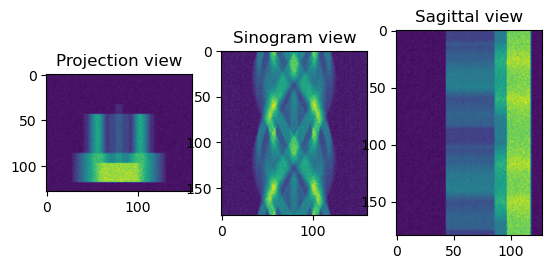

In [1]:
import os
import numpy as np
import cupy as cp
import httomolibgpu
import matplotlib.pyplot as plt
from httomolibgpu.prep.normalize import normalize

# Load the projection data
path_lib = os.path.dirname(httomolibgpu.__file__)
in_file = os.path.abspath(
    os.path.join(path_lib, "..", "tests/test_data/", "tomo_standard.npz")
)
datafile = np.load(in_file)
host_data = datafile["data"]
host_flats = datafile["flats"]
host_darks = datafile["darks"]

print(
    "The shape of the data is {} as (projections, detector Y, detector X)".format(
        np.shape(host_data)
    )
)

print("Normalising the data")
data = cp.asarray(host_data)
flats = cp.asarray(host_flats)
darks = cp.asarray(host_darks)
data_normalised = normalize(data, flats, darks, cutoff=10, minus_log=True)

sliceSel = 64
data_normalised_np = data_normalised.get()

plt.figure()
plt.subplot(131)
plt.imshow(data_normalised_np[sliceSel, :, :])
plt.title("Projection view")

plt.subplot(132)
plt.imshow(data_normalised_np[:, sliceSel, :])
plt.title("Sinogram view")

plt.subplot(133)
plt.imshow(data_normalised_np[:, :, sliceSel])
plt.title("Sagittal view")
plt.show()

In [2]:
from httomolibgpu.recon.rotation import find_center_pc

print("Finding the Center of Rotation for the reconstruction")
cor = find_center_pc(proj1=data_normalised[0, :, :], proj2=data_normalised[179, :, :])
print("The found Center of Rotation is {}".format(cor))

Finding the Center of Rotation for the reconstruction
 Platform does not have any supported GPU!
 Platform verification failed
 platform is not supported by cufile
 cuFile initialization failed
The found Center of Rotation is 79.5


Perform Reconstruction using CGLS


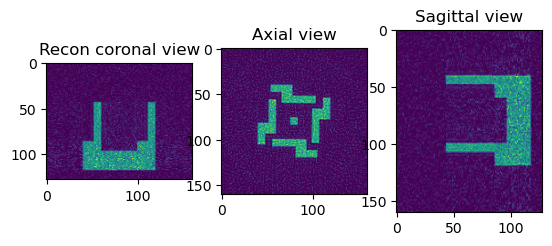

In [3]:
print("Perform Reconstruction using CGLS")

from httomolibgpu.recon.algorithm import CGLS

angles = np.linspace(0.0 * np.pi / 180.0, 180.0 * np.pi / 180.0, data.shape[0])

reconCGLS = CGLS(data_normalised, angles=angles, center=cor, iterations=20)

reconCGLS_np = reconCGLS.get()

sliceSel = 64
plt.figure()
plt.subplot(131)
plt.imshow(reconCGLS_np[sliceSel, :, :])
plt.title("Recon coronal view")

plt.subplot(132)
plt.imshow(reconCGLS_np[:, sliceSel, :])
plt.title("Axial view")

plt.subplot(133)
plt.imshow(reconCGLS_np[:, :, sliceSel])
plt.title("Sagittal view")
plt.show()